# Sequence 2 Sequence Model

In [1]:
### https://towardsdatascience.com/solving-nlp-task-using-sequence2sequence-model-from-zero-to-hero-c193c1bd03d1
### https://github.com/shudima/notebooks/blob/master/NER.ipynb

In [2]:
import os
import math
import itertools
import numpy as np
import pandas as pd

from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline


In [3]:
try:
    basestring
except NameError:
    basestring = str

In [90]:
ner_df = pd.read_csv('ner_dataset.csv', encoding="ISO-8859-1")
#ner_df['Word'] = ner_df['Word'].str.lower()

In [91]:
ner_df.head(30)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O
5,NaN,through,IN,O
6,NaN,London,NNP,B-geo
7,NaN,to,TO,O
8,NaN,protest,VB,O
9,NaN,the,DT,O


In [92]:
sentences_words = []
sentences_tags = []
curr_sent_num = -1
current_sentence_words = []
current_sentence_tags = []
for sent_num, word, tag in ner_df[['Sentence #', 'Word', 'Tag']].values:   
    if isinstance(sent_num, basestring) and 'Sentence: ' in sent_num:
        curr_sent_num = int(sent_num.split(':')[1].strip())
        
        if current_sentence_words and current_sentence_tags:
            sentences_words.append(current_sentence_words)
            sentences_tags.append(current_sentence_tags)
            
        current_sentence_words = []
        current_sentence_tags = []
    
    current_sentence_words.append(word.encode(encoding='ISO-8859-1', ).decode(errors='replace'))
    current_sentence_tags.append(tag)

len(sentences_words), len(sentences_tags)

(47960, 47960)

In [93]:
for w, k in zip(sentences_words[123], sentences_tags[123]):
    print(w, k)


Not O
counting O
the O
latest O
death O
, O
the O
World B-org
Health I-org
Organization I-org
says O
227 O
people O
around O
the O
world O
have O
died O
from O
bird O
flu O
since O
2003 B-tim
. O


In [94]:
train_size = int(len(sentences_words) * 0.8)

train_sentences_words = sentences_words[:train_size]
train_sentences_tags = sentences_tags[:train_size]
test_sentences_words = sentences_words[train_size:]
test_sentences_tags = sentences_tags[train_size:]

print('Train:', len(train_sentences_words), len(train_sentences_tags))
print('Test:', len(test_sentences_words), len(test_sentences_tags))

Train: 38368 38368
Test: 9592 9592


# BoW + Cls Benchmark

In [95]:
import scipy
from sklearn.feature_extraction.text import CountVectorizer


In [96]:
def sentence_to_instances(words, tags, bow, count_vectorizer):
    X = []
    y = []
    for w, t in zip(words, tags):
        v = count_vectorizer.transform([w])[0]
        v = scipy.sparse.hstack([v, bow])
        X.append(v)
        y.append(t)
        
    return scipy.sparse.vstack(X), y

def sentences_to_instances(sentences_words, sentences_tags, count_vectorizer):
    bows = count_vectorizer.transform(map(lambda s: ' '.join(s), sentences_words))
    X = []
    y = []
    for words, tags, bow in zip(sentences_words, sentences_tags, bows):
        sent_X, sent_y = sentence_to_instances(words, tags, bow, count_vectorizer)
        X.append(sent_X)
        y += sent_y
        
    return scipy.sparse.vstack(X), np.array(y)

In [97]:
count_vectorizer = CountVectorizer(dtype='int32').fit(map(lambda s: ' '.join(s), train_sentences_words))
count_vectorizer

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype='int32', encoding='utf-8', input='content', lowercase=True,
        max_df=1.0, max_features=None, min_df=1, ngram_range=(1, 1),
        preprocessor=None, stop_words=None, strip_accents=None,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, vocabulary=None)

In [98]:
%time train_X, train_y = sentences_to_instances(train_sentences_words, train_sentences_tags, count_vectorizer)


Wall time: 7min 19s


In [99]:
train_X.shape, train_y.shape

((839270, 50892), (839270,))

In [100]:
%time test_X, test_y = sentences_to_instances(test_sentences_words, test_sentences_tags, count_vectorizer)


Wall time: 1min 46s


In [101]:
test_X.shape, test_y.shape

((209313, 50892), (209313,))

In [102]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report

In [103]:
clf = GradientBoostingClassifier()
clf

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              n_iter_no_change=None, presort='auto', random_state=None,
              subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [104]:
#break;

In [107]:
%time clf.fit(train_X, train_y)

In [108]:
predicted = clf.predict(test_X)

In [ ]:
print(classification_report(test_y, predicted))

# Prepare for Seq2Seq

In [109]:
vocab = set(itertools.chain(*[[w for w in s] for s in train_sentences_words])) 
vocab

{'CONVENTION',
 'Seasonal',
 'match-fixing',
 'Arabiya',
 'Bayrou',
 'tentatively',
 'haggling',
 'Jacob',
 'tunnel',
 'Serbs',
 '2035',
 'timeline',
 'faulting',
 'From',
 'Pressure',
 'Admiral',
 'flood',
 'Orbiter',
 'high-technology',
 '9.5',
 'perceptions',
 'defying',
 'sir',
 'blanked',
 'involvement',
 'cell-phone',
 'firecrackers',
 'lucrative',
 'Islamists',
 'Persistent',
 'payroll',
 'shook',
 'credit',
 'unrealistic',
 '178',
 'overboard',
 '84th',
 'Strategy',
 'Fort',
 'Karachi',
 'converted',
 'Nidal',
 'indissoluble',
 'Sita',
 'Broncos',
 'includes',
 'Eyadema',
 'Housing',
 'conspiring',
 '3.4',
 'risks',
 'Associates',
 'commodities',
 'Champions',
 'Doug',
 'trash',
 'plateau',
 'Sunni-dominant',
 'Miami',
 'Landale',
 'surrounded',
 'daunting',
 'Tajouri',
 'reassessed',
 'detailing',
 'simultaneous',
 'Porto',
 'Bagosora',
 'Torgelow',
 '22,000',
 'Oaxaca',
 'Frankenstadion',
 'mobilized',
 'Janica',
 'Scooter',
 'Gazeta',
 'Aftab',
 'Approximately',
 'Rezko',
 '

In [110]:
tags = set(itertools.chain(*[[w for w in s] for s in train_sentences_tags]))
tags

{'B-art',
 'B-eve',
 'B-geo',
 'B-gpe',
 'B-nat',
 'B-org',
 'B-per',
 'B-tim',
 'I-art',
 'I-eve',
 'I-geo',
 'I-gpe',
 'I-nat',
 'I-org',
 'I-per',
 'I-tim',
 'O'}

In [111]:
sentences_lens = map(len, train_sentences_words)
sentences_lens = list(sentences_lens)
len(sentences_lens)

38368

In [112]:
len(vocab), len(tags), 

(31809, 17)

In [113]:
max(sentences_lens)

104

(array([3.5510e+03, 1.5670e+04, 1.4855e+04, 3.8900e+03, 3.3800e+02,
        5.2000e+01, 1.0000e+01, 1.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([  1. ,  11.3,  21.6,  31.9,  42.2,  52.5,  62.8,  73.1,  83.4,
         93.7, 104. ]),
 <a list of 10 Patch objects>)

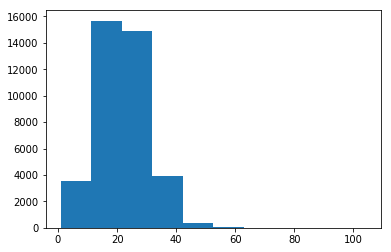

In [114]:
plt.hist(sentences_lens)

In [115]:
# MAX_LEN = 75 
MAX_LEN = max(sentences_lens)
VOCAB_SIZE = len(vocab)

In [117]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [118]:
words_tokenizer = Tokenizer(num_words=VOCAB_SIZE, filters=[], oov_token='__UNKNOWN__')
words_tokenizer

In [119]:
words_tokenizer.fit_on_texts(map(lambda s: ' '.join(s), train_sentences_words))


In [120]:
word_index = words_tokenizer.word_index
word_index['__PADDING__'] = 0
word_index['circle']

13508

In [121]:
# [(k,v) for k,v in word_index.items()]

In [122]:
index_word = {i:w for w, i in word_index.items()}
print('Unique tokens:', len(word_index))

Unique tokens: 28824


In [157]:
train_sequences = words_tokenizer.texts_to_sequences(map(lambda s: ' '.join(s), train_sentences_words))
test_sequences = words_tokenizer.texts_to_sequences(map(lambda s: ' '.join(s), test_sentences_words))
print(len(train_sequences), len(test_sequences))

38368 9592


In [158]:
train_sequences_padded = pad_sequences(train_sequences, maxlen=MAX_LEN)
test_sequences_padded = pad_sequences(test_sequences, maxlen=MAX_LEN)
print(train_sequences_padded.shape, test_sequences_padded.shape)

(38368, 104) (9592, 104)


In [159]:
tags_tokenizer = Tokenizer(num_words=len(tags), filters='', oov_token='__UNKNOWN__', lower=False)
tags_tokenizer

In [160]:
tags_tokenizer.fit_on_texts(map(lambda s: ' '.join(s), train_sentences_tags))


In [161]:
tag_index = tags_tokenizer.word_index
tag_index['__PADDING__'] = 0
tag_index

{'__UNKNOWN__': 1,
 'O': 2,
 'B-geo': 3,
 'B-tim': 4,
 'B-org': 5,
 'I-per': 6,
 'B-per': 7,
 'I-org': 8,
 'B-gpe': 9,
 'I-geo': 10,
 'I-tim': 11,
 'B-art': 12,
 'B-eve': 13,
 'I-art': 14,
 'I-eve': 15,
 'I-gpe': 16,
 'B-nat': 17,
 'I-nat': 18,
 '__PADDING__': 0}

In [162]:
index_tag = {i:w for w, i in tag_index.items()}

index_tag_wo_padding = dict(index_tag)
index_tag_wo_padding[tag_index['__PADDING__']] = '0'
print('Unique tags:', len(tag_index))

Unique tags: 19


In [163]:
train_tags = tags_tokenizer.texts_to_sequences(map(lambda s: ' '.join(s), train_sentences_tags))
test_tags = tags_tokenizer.texts_to_sequences(map(lambda s: ' '.join(s), test_sentences_tags))
len(train_tags), len(test_tags)

(38368, 9592)

In [164]:
train_tags_padded = pad_sequences(train_tags, maxlen=MAX_LEN)
test_tags_padded = pad_sequences(test_tags, maxlen=MAX_LEN)

train_tags_padded = np.expand_dims(train_tags_padded, -1)
test_tags_padded = np.expand_dims(test_tags_padded, -1)
print(train_tags_padded.shape, test_tags_padded.shape)

(38368, 104, 1) (9592, 104, 1)


In [165]:
type(test_tags_padded)

numpy.ndarray

In [166]:
for w, t in zip(train_sequences_padded[123], train_tags_padded[123]):
    print(index_word[w], index_tag[t[0]])

__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PADDING__
__PADDING__ __PA

# Bi-LSTM 

In [133]:
from keras.layers import Dense, Input, LSTM, Embedding, Bidirectional, Dropout
from keras.models import Model
from keras.initializers import Constant

In [134]:
# VOCAB_SIZE = len(vocab)
VOCAB_SIZE

31809

In [135]:
MAX_LEN

104

In [136]:
len(tag_index)

19

In [179]:
random_embedding_layer = Embedding(VOCAB_SIZE,
                                300,
                                input_length=MAX_LEN)

sequence_input = Input(shape=(MAX_LEN,), dtype='int32')
embedded_sequences = random_embedding_layer(sequence_input)
x = Bidirectional(LSTM(64, return_sequences=True))(embedded_sequences)
x = Dropout(0.3)(x)
x = Dense(32, activation='relu')(x)
preds = Dense(len(tag_index), activation='softmax')(x)

model = Model(sequence_input, preds)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              #metrics=['sparse_categorical_accuracy'])
              metrics=['categorical_accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 104)               0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 104, 300)          9542700   
_________________________________________________________________
bidirectional_4 (Bidirection (None, 104, 128)          186880    
_________________________________________________________________
dropout_4 (Dropout)          (None, 104, 128)          0         
_________________________________________________________________
dense_7 (Dense)              (None, 104, 32)           4128      
_________________________________________________________________
dense_8 (Dense)              (None, 104, 19)           627       
Total params: 9,734,335
Trainable params: 9,734,335
Non-trainable params: 0
_________________________________________________________________


In [175]:
train_sequences_padded.shape, test_sequences_padded.shape

((38368, 104), (9592, 104))

In [176]:
train_tags_padded.shape, test_tags_padded.shape

((38368, 104, 1), (9592, 104, 1))

In [177]:
for x, y in zip(train_sequences_padded, train_tags_padded):
    if len(x) != len(y):
        print(len(x), len(y))

In [178]:
for x, y in zip(test_sequences_padded, test_tags_padded):
    if len(x) != len(y):
        print(len(x), len(y))

In [ ]:
%time model.fit(train_sequences_padded, train_tags_padded,
          batch_size=32, epochs=10,
          validation_data=(test_sequences_padded, test_tags_padded))

Train on 38368 samples, validate on 9592 samples
Epoch 1/10


 4608/38368 [==>...........................] - ETA: 56:11 - loss: 2.9644 - categorical_accuracy: 9.0144e-0 - ETA: 31:35 - loss: 2.9392 - categorical_accuracy: 0.0496    - ETA: 23:50 - loss: 2.9174 - categorical_accuracy: 0.204 - ETA: 19:38 - loss: 2.8948 - categorical_accuracy: 0.339 - ETA: 17:01 - loss: 2.8692 - categorical_accuracy: 0.445 - ETA: 15:19 - loss: 2.8417 - categorical_accuracy: 0.522 - ETA: 14:05 - loss: 2.8099 - categorical_accuracy: 0.581 - ETA: 13:09 - loss: 2.7770 - categorical_accuracy: 0.624 - ETA: 12:27 - loss: 2.7360 - categorical_accuracy: 0.661 - ETA: 11:53 - loss: 2.6889 - categorical_accuracy: 0.692 - ETA: 11:24 - loss: 2.6396 - categorical_accuracy: 0.715 - ETA: 11:02 - loss: 2.5830 - categorical_accuracy: 0.737 - ETA: 10:44 - loss: 2.5209 - categorical_accuracy: 0.754 - ETA: 10:32 - loss: 2.4509 - categorical_accuracy: 0.770 - ETA: 10:24 - loss: 2.3779 - categorical_accuracy: 0.785 - ETA: 10:13 - loss: 2.3037 - categorical_accuracy: 0.798 - ETA: 10:16 - loss

 9280/38368 [======>.......................] - ETA: 6:49 - loss: 0.4709 - categorical_accuracy: 0.80 - ETA: 6:49 - loss: 0.4685 - categorical_accuracy: 0.80 - ETA: 6:49 - loss: 0.4662 - categorical_accuracy: 0.80 - ETA: 6:49 - loss: 0.4639 - categorical_accuracy: 0.80 - ETA: 6:49 - loss: 0.4616 - categorical_accuracy: 0.80 - ETA: 6:49 - loss: 0.4595 - categorical_accuracy: 0.80 - ETA: 6:49 - loss: 0.4573 - categorical_accuracy: 0.80 - ETA: 6:49 - loss: 0.4551 - categorical_accuracy: 0.80 - ETA: 6:49 - loss: 0.4529 - categorical_accuracy: 0.80 - ETA: 6:48 - loss: 0.4510 - categorical_accuracy: 0.80 - ETA: 6:48 - loss: 0.4488 - categorical_accuracy: 0.80 - ETA: 6:47 - loss: 0.4466 - categorical_accuracy: 0.80 - ETA: 6:46 - loss: 0.4443 - categorical_accuracy: 0.80 - ETA: 6:46 - loss: 0.4421 - categorical_accuracy: 0.80 - ETA: 6:45 - loss: 0.4402 - categorical_accuracy: 0.80 - ETA: 6:44 - loss: 0.4382 - categorical_accuracy: 0.80 - ETA: 6:44 - loss: 0.4362 - categorical_accuracy: 0.80 - E

13952/38368 [=========>....................] - ETA: 5:42 - loss: 0.2867 - categorical_accuracy: 0.79 - ETA: 5:42 - loss: 0.2861 - categorical_accuracy: 0.79 - ETA: 5:42 - loss: 0.2854 - categorical_accuracy: 0.79 - ETA: 5:41 - loss: 0.2847 - categorical_accuracy: 0.79 - ETA: 5:41 - loss: 0.2840 - categorical_accuracy: 0.79 - ETA: 5:41 - loss: 0.2833 - categorical_accuracy: 0.79 - ETA: 5:40 - loss: 0.2826 - categorical_accuracy: 0.79 - ETA: 5:40 - loss: 0.2820 - categorical_accuracy: 0.79 - ETA: 5:40 - loss: 0.2813 - categorical_accuracy: 0.79 - ETA: 5:39 - loss: 0.2807 - categorical_accuracy: 0.79 - ETA: 5:39 - loss: 0.2800 - categorical_accuracy: 0.79 - ETA: 5:39 - loss: 0.2794 - categorical_accuracy: 0.79 - ETA: 5:39 - loss: 0.2787 - categorical_accuracy: 0.79 - ETA: 5:38 - loss: 0.2780 - categorical_accuracy: 0.79 - ETA: 5:38 - loss: 0.2774 - categorical_accuracy: 0.79 - ETA: 5:38 - loss: 0.2767 - categorical_accuracy: 0.79 - ETA: 5:37 - loss: 0.2761 - categorical_accuracy: 0.79 - E

18624/38368 [=============>................] - ETA: 4:50 - loss: 0.2150 - categorical_accuracy: 0.79 - ETA: 4:49 - loss: 0.2146 - categorical_accuracy: 0.79 - ETA: 4:49 - loss: 0.2143 - categorical_accuracy: 0.79 - ETA: 4:48 - loss: 0.2139 - categorical_accuracy: 0.79 - ETA: 4:48 - loss: 0.2136 - categorical_accuracy: 0.79 - ETA: 4:48 - loss: 0.2132 - categorical_accuracy: 0.79 - ETA: 4:47 - loss: 0.2129 - categorical_accuracy: 0.79 - ETA: 4:47 - loss: 0.2126 - categorical_accuracy: 0.79 - ETA: 4:46 - loss: 0.2123 - categorical_accuracy: 0.79 - ETA: 4:46 - loss: 0.2119 - categorical_accuracy: 0.79 - ETA: 4:46 - loss: 0.2115 - categorical_accuracy: 0.79 - ETA: 4:45 - loss: 0.2112 - categorical_accuracy: 0.79 - ETA: 4:45 - loss: 0.2108 - categorical_accuracy: 0.79 - ETA: 4:45 - loss: 0.2105 - categorical_accuracy: 0.79 - ETA: 4:44 - loss: 0.2101 - categorical_accuracy: 0.79 - ETA: 4:44 - loss: 0.2098 - categorical_accuracy: 0.79 - ETA: 4:44 - loss: 0.2094 - categorical_accuracy: 0.79 - E

23296/38368 [=================>............] - ETA: 3:59 - loss: 0.1748 - categorical_accuracy: 0.79 - ETA: 3:59 - loss: 0.1745 - categorical_accuracy: 0.79 - ETA: 3:59 - loss: 0.1744 - categorical_accuracy: 0.79 - ETA: 3:58 - loss: 0.1742 - categorical_accuracy: 0.79 - ETA: 3:58 - loss: 0.1740 - categorical_accuracy: 0.79 - ETA: 3:58 - loss: 0.1738 - categorical_accuracy: 0.79 - ETA: 3:57 - loss: 0.1735 - categorical_accuracy: 0.79 - ETA: 3:57 - loss: 0.1733 - categorical_accuracy: 0.79 - ETA: 3:57 - loss: 0.1732 - categorical_accuracy: 0.79 - ETA: 3:56 - loss: 0.1729 - categorical_accuracy: 0.79 - ETA: 3:56 - loss: 0.1727 - categorical_accuracy: 0.79 - ETA: 3:56 - loss: 0.1725 - categorical_accuracy: 0.79 - ETA: 3:55 - loss: 0.1723 - categorical_accuracy: 0.79 - ETA: 3:55 - loss: 0.1721 - categorical_accuracy: 0.79 - ETA: 3:55 - loss: 0.1719 - categorical_accuracy: 0.79 - ETA: 3:54 - loss: 0.1717 - categorical_accuracy: 0.79 - ETA: 3:54 - loss: 0.1715 - categorical_accuracy: 0.79 - E

27968/38368 [====================>.........] - ETA: 3:04 - loss: 0.1491 - categorical_accuracy: 0.79 - ETA: 3:04 - loss: 0.1489 - categorical_accuracy: 0.79 - ETA: 3:03 - loss: 0.1488 - categorical_accuracy: 0.79 - ETA: 3:03 - loss: 0.1486 - categorical_accuracy: 0.79 - ETA: 3:03 - loss: 0.1485 - categorical_accuracy: 0.79 - ETA: 3:02 - loss: 0.1483 - categorical_accuracy: 0.79 - ETA: 3:02 - loss: 0.1482 - categorical_accuracy: 0.79 - ETA: 3:01 - loss: 0.1480 - categorical_accuracy: 0.79 - ETA: 3:01 - loss: 0.1479 - categorical_accuracy: 0.79 - ETA: 3:01 - loss: 0.1477 - categorical_accuracy: 0.79 - ETA: 3:00 - loss: 0.1476 - categorical_accuracy: 0.79 - ETA: 3:00 - loss: 0.1474 - categorical_accuracy: 0.79 - ETA: 2:59 - loss: 0.1473 - categorical_accuracy: 0.79 - ETA: 2:59 - loss: 0.1471 - categorical_accuracy: 0.79 - ETA: 2:59 - loss: 0.1470 - categorical_accuracy: 0.79 - ETA: 2:58 - loss: 0.1468 - categorical_accuracy: 0.79 - ETA: 2:58 - loss: 0.1467 - categorical_accuracy: 0.79 - E

32640/38368 [========================>.....] - ETA: 2:07 - loss: 0.1310 - categorical_accuracy: 0.79 - ETA: 2:06 - loss: 0.1309 - categorical_accuracy: 0.79 - ETA: 2:06 - loss: 0.1308 - categorical_accuracy: 0.79 - ETA: 2:06 - loss: 0.1307 - categorical_accuracy: 0.79 - ETA: 2:05 - loss: 0.1306 - categorical_accuracy: 0.79 - ETA: 2:05 - loss: 0.1305 - categorical_accuracy: 0.79 - ETA: 2:04 - loss: 0.1304 - categorical_accuracy: 0.79 - ETA: 2:04 - loss: 0.1303 - categorical_accuracy: 0.79 - ETA: 2:04 - loss: 0.1302 - categorical_accuracy: 0.79 - ETA: 2:03 - loss: 0.1301 - categorical_accuracy: 0.79 - ETA: 2:03 - loss: 0.1300 - categorical_accuracy: 0.79 - ETA: 2:03 - loss: 0.1299 - categorical_accuracy: 0.79 - ETA: 2:02 - loss: 0.1298 - categorical_accuracy: 0.79 - ETA: 2:02 - loss: 0.1297 - categorical_accuracy: 0.79 - ETA: 2:01 - loss: 0.1296 - categorical_accuracy: 0.79 - ETA: 2:01 - loss: 0.1295 - categorical_accuracy: 0.79 - ETA: 2:01 - loss: 0.1294 - categorical_accuracy: 0.79 - E

37312/38368 [============================>.] - ETA: 1:10 - loss: 0.1179 - categorical_accuracy: 0.79 - ETA: 1:09 - loss: 0.1178 - categorical_accuracy: 0.79 - ETA: 1:09 - loss: 0.1177 - categorical_accuracy: 0.79 - ETA: 1:09 - loss: 0.1176 - categorical_accuracy: 0.79 - ETA: 1:08 - loss: 0.1175 - categorical_accuracy: 0.79 - ETA: 1:08 - loss: 0.1175 - categorical_accuracy: 0.79 - ETA: 1:07 - loss: 0.1174 - categorical_accuracy: 0.79 - ETA: 1:07 - loss: 0.1173 - categorical_accuracy: 0.79 - ETA: 1:07 - loss: 0.1172 - categorical_accuracy: 0.79 - ETA: 1:06 - loss: 0.1171 - categorical_accuracy: 0.79 - ETA: 1:06 - loss: 0.1171 - categorical_accuracy: 0.79 - ETA: 1:06 - loss: 0.1170 - categorical_accuracy: 0.79 - ETA: 1:05 - loss: 0.1169 - categorical_accuracy: 0.79 - ETA: 1:05 - loss: 0.1168 - categorical_accuracy: 0.79 - ETA: 1:04 - loss: 0.1167 - categorical_accuracy: 0.79 - ETA: 1:04 - loss: 0.1167 - categorical_accuracy: 0.79 - ETA: 1:04 - loss: 0.1166 - categorical_accuracy: 0.79 - E

38368/38368 [==============================] - ETA: 12s - loss: 0.1075 - categorical_accuracy: 0.792 - ETA: 12s - loss: 0.1074 - categorical_accuracy: 0.792 - ETA: 11s - loss: 0.1073 - categorical_accuracy: 0.792 - ETA: 11s - loss: 0.1073 - categorical_accuracy: 0.792 - ETA: 11s - loss: 0.1072 - categorical_accuracy: 0.792 - ETA: 10s - loss: 0.1071 - categorical_accuracy: 0.792 - ETA: 10s - loss: 0.1071 - categorical_accuracy: 0.792 - ETA: 9s - loss: 0.1070 - categorical_accuracy: 0.792 - ETA: 9s - loss: 0.1069 - categorical_accuracy: 0.79 - ETA: 9s - loss: 0.1069 - categorical_accuracy: 0.79 - ETA: 8s - loss: 0.1068 - categorical_accuracy: 0.79 - ETA: 8s - loss: 0.1067 - categorical_accuracy: 0.79 - ETA: 7s - loss: 0.1067 - categorical_accuracy: 0.79 - ETA: 7s - loss: 0.1066 - categorical_accuracy: 0.79 - ETA: 7s - loss: 0.1066 - categorical_accuracy: 0.79 - ETA: 6s - loss: 0.1065 - categorical_accuracy: 0.79 - ETA: 6s - loss: 0.1064 - categorical_accuracy: 0.79 - ETA: 5s - loss: 0.10

 4672/38368 [==>...........................] - ETA: 8:03 - loss: 0.0264 - categorical_accuracy: 0.79 - ETA: 7:53 - loss: 0.0215 - categorical_accuracy: 0.78 - ETA: 7:48 - loss: 0.0300 - categorical_accuracy: 0.78 - ETA: 8:08 - loss: 0.0304 - categorical_accuracy: 0.78 - ETA: 7:57 - loss: 0.0277 - categorical_accuracy: 0.78 - ETA: 7:51 - loss: 0.0292 - categorical_accuracy: 0.78 - ETA: 7:50 - loss: 0.0320 - categorical_accuracy: 0.78 - ETA: 7:47 - loss: 0.0314 - categorical_accuracy: 0.78 - ETA: 7:47 - loss: 0.0338 - categorical_accuracy: 0.78 - ETA: 7:46 - loss: 0.0323 - categorical_accuracy: 0.78 - ETA: 7:47 - loss: 0.0320 - categorical_accuracy: 0.78 - ETA: 7:52 - loss: 0.0313 - categorical_accuracy: 0.78 - ETA: 7:54 - loss: 0.0305 - categorical_accuracy: 0.78 - ETA: 7:55 - loss: 0.0298 - categorical_accuracy: 0.78 - ETA: 8:00 - loss: 0.0293 - categorical_accuracy: 0.78 - ETA: 8:03 - loss: 0.0293 - categorical_accuracy: 0.78 - ETA: 8:04 - loss: 0.0293 - categorical_accuracy: 0.78 - E

 9344/38368 [======>.......................] - ETA: 7:31 - loss: 0.0278 - categorical_accuracy: 0.79 - ETA: 7:30 - loss: 0.0277 - categorical_accuracy: 0.79 - ETA: 7:30 - loss: 0.0278 - categorical_accuracy: 0.78 - ETA: 7:29 - loss: 0.0277 - categorical_accuracy: 0.79 - ETA: 7:29 - loss: 0.0277 - categorical_accuracy: 0.79 - ETA: 7:28 - loss: 0.0276 - categorical_accuracy: 0.79 - ETA: 7:28 - loss: 0.0275 - categorical_accuracy: 0.79 - ETA: 7:27 - loss: 0.0275 - categorical_accuracy: 0.79 - ETA: 7:27 - loss: 0.0275 - categorical_accuracy: 0.79 - ETA: 7:27 - loss: 0.0275 - categorical_accuracy: 0.79 - ETA: 7:26 - loss: 0.0274 - categorical_accuracy: 0.79 - ETA: 7:26 - loss: 0.0275 - categorical_accuracy: 0.79 - ETA: 7:26 - loss: 0.0275 - categorical_accuracy: 0.78 - ETA: 7:25 - loss: 0.0275 - categorical_accuracy: 0.78 - ETA: 7:25 - loss: 0.0275 - categorical_accuracy: 0.78 - ETA: 7:25 - loss: 0.0275 - categorical_accuracy: 0.78 - ETA: 7:25 - loss: 0.0275 - categorical_accuracy: 0.79 - E

14016/38368 [=========>....................] - ETA: 6:30 - loss: 0.0275 - categorical_accuracy: 0.79 - ETA: 6:30 - loss: 0.0275 - categorical_accuracy: 0.79 - ETA: 6:29 - loss: 0.0275 - categorical_accuracy: 0.79 - ETA: 6:29 - loss: 0.0275 - categorical_accuracy: 0.79 - ETA: 6:28 - loss: 0.0275 - categorical_accuracy: 0.79 - ETA: 6:28 - loss: 0.0275 - categorical_accuracy: 0.79 - ETA: 6:27 - loss: 0.0275 - categorical_accuracy: 0.79 - ETA: 6:26 - loss: 0.0275 - categorical_accuracy: 0.79 - ETA: 6:26 - loss: 0.0274 - categorical_accuracy: 0.79 - ETA: 6:25 - loss: 0.0274 - categorical_accuracy: 0.79 - ETA: 6:25 - loss: 0.0274 - categorical_accuracy: 0.79 - ETA: 6:24 - loss: 0.0274 - categorical_accuracy: 0.79 - ETA: 6:24 - loss: 0.0274 - categorical_accuracy: 0.79 - ETA: 6:23 - loss: 0.0274 - categorical_accuracy: 0.79 - ETA: 6:23 - loss: 0.0274 - categorical_accuracy: 0.79 - ETA: 6:23 - loss: 0.0273 - categorical_accuracy: 0.79 - ETA: 6:22 - loss: 0.0274 - categorical_accuracy: 0.79 - E

18688/38368 [=============>................] - ETA: 5:21 - loss: 0.0274 - categorical_accuracy: 0.79 - ETA: 5:21 - loss: 0.0274 - categorical_accuracy: 0.79 - ETA: 5:20 - loss: 0.0274 - categorical_accuracy: 0.79 - ETA: 5:20 - loss: 0.0274 - categorical_accuracy: 0.79 - ETA: 5:19 - loss: 0.0273 - categorical_accuracy: 0.79 - ETA: 5:19 - loss: 0.0273 - categorical_accuracy: 0.79 - ETA: 5:18 - loss: 0.0274 - categorical_accuracy: 0.79 - ETA: 5:18 - loss: 0.0274 - categorical_accuracy: 0.79 - ETA: 5:17 - loss: 0.0274 - categorical_accuracy: 0.79 - ETA: 5:17 - loss: 0.0274 - categorical_accuracy: 0.79 - ETA: 5:17 - loss: 0.0274 - categorical_accuracy: 0.79 - ETA: 5:16 - loss: 0.0274 - categorical_accuracy: 0.79 - ETA: 5:16 - loss: 0.0274 - categorical_accuracy: 0.79 - ETA: 5:15 - loss: 0.0274 - categorical_accuracy: 0.79 - ETA: 5:15 - loss: 0.0274 - categorical_accuracy: 0.79 - ETA: 5:14 - loss: 0.0274 - categorical_accuracy: 0.79 - ETA: 5:14 - loss: 0.0274 - categorical_accuracy: 0.79 - E

23360/38368 [=================>............] - ETA: 4:17 - loss: 0.0272 - categorical_accuracy: 0.78 - ETA: 4:17 - loss: 0.0272 - categorical_accuracy: 0.78 - ETA: 4:16 - loss: 0.0272 - categorical_accuracy: 0.78 - ETA: 4:16 - loss: 0.0272 - categorical_accuracy: 0.78 - ETA: 4:16 - loss: 0.0272 - categorical_accuracy: 0.78 - ETA: 4:15 - loss: 0.0272 - categorical_accuracy: 0.78 - ETA: 4:15 - loss: 0.0272 - categorical_accuracy: 0.78 - ETA: 4:14 - loss: 0.0272 - categorical_accuracy: 0.78 - ETA: 4:14 - loss: 0.0272 - categorical_accuracy: 0.78 - ETA: 4:13 - loss: 0.0272 - categorical_accuracy: 0.78 - ETA: 4:13 - loss: 0.0272 - categorical_accuracy: 0.78 - ETA: 4:12 - loss: 0.0272 - categorical_accuracy: 0.78 - ETA: 4:12 - loss: 0.0271 - categorical_accuracy: 0.78 - ETA: 4:11 - loss: 0.0272 - categorical_accuracy: 0.78 - ETA: 4:11 - loss: 0.0272 - categorical_accuracy: 0.78 - ETA: 4:11 - loss: 0.0272 - categorical_accuracy: 0.78 - ETA: 4:10 - loss: 0.0271 - categorical_accuracy: 0.78 - E

28032/38368 [====================>.........] - ETA: 3:15 - loss: 0.0270 - categorical_accuracy: 0.78 - ETA: 3:14 - loss: 0.0270 - categorical_accuracy: 0.78 - ETA: 3:14 - loss: 0.0270 - categorical_accuracy: 0.78 - ETA: 3:13 - loss: 0.0270 - categorical_accuracy: 0.78 - ETA: 3:13 - loss: 0.0270 - categorical_accuracy: 0.78 - ETA: 3:12 - loss: 0.0270 - categorical_accuracy: 0.78 - ETA: 3:12 - loss: 0.0270 - categorical_accuracy: 0.78 - ETA: 3:11 - loss: 0.0270 - categorical_accuracy: 0.78 - ETA: 3:11 - loss: 0.0270 - categorical_accuracy: 0.78 - ETA: 3:11 - loss: 0.0270 - categorical_accuracy: 0.78 - ETA: 3:10 - loss: 0.0270 - categorical_accuracy: 0.78 - ETA: 3:10 - loss: 0.0270 - categorical_accuracy: 0.78 - ETA: 3:09 - loss: 0.0270 - categorical_accuracy: 0.78 - ETA: 3:09 - loss: 0.0270 - categorical_accuracy: 0.78 - ETA: 3:08 - loss: 0.0270 - categorical_accuracy: 0.78 - ETA: 3:08 - loss: 0.0270 - categorical_accuracy: 0.78 - ETA: 3:07 - loss: 0.0270 - categorical_accuracy: 0.78 - E

32704/38368 [========================>.....] - ETA: 2:12 - loss: 0.0271 - categorical_accuracy: 0.78 - ETA: 2:12 - loss: 0.0271 - categorical_accuracy: 0.78 - ETA: 2:11 - loss: 0.0271 - categorical_accuracy: 0.78 - ETA: 2:11 - loss: 0.0271 - categorical_accuracy: 0.78 - ETA: 2:10 - loss: 0.0271 - categorical_accuracy: 0.78 - ETA: 2:10 - loss: 0.0271 - categorical_accuracy: 0.78 - ETA: 2:10 - loss: 0.0271 - categorical_accuracy: 0.78 - ETA: 2:09 - loss: 0.0271 - categorical_accuracy: 0.78 - ETA: 2:09 - loss: 0.0271 - categorical_accuracy: 0.78 - ETA: 2:08 - loss: 0.0271 - categorical_accuracy: 0.78 - ETA: 2:08 - loss: 0.0271 - categorical_accuracy: 0.78 - ETA: 2:08 - loss: 0.0271 - categorical_accuracy: 0.78 - ETA: 2:07 - loss: 0.0271 - categorical_accuracy: 0.78 - ETA: 2:07 - loss: 0.0271 - categorical_accuracy: 0.78 - ETA: 2:06 - loss: 0.0271 - categorical_accuracy: 0.78 - ETA: 2:06 - loss: 0.0271 - categorical_accuracy: 0.78 - ETA: 2:06 - loss: 0.0271 - categorical_accuracy: 0.78 - E

37376/38368 [============================>.] - ETA: 1:12 - loss: 0.0269 - categorical_accuracy: 0.78 - ETA: 1:12 - loss: 0.0269 - categorical_accuracy: 0.78 - ETA: 1:11 - loss: 0.0269 - categorical_accuracy: 0.78 - ETA: 1:11 - loss: 0.0269 - categorical_accuracy: 0.78 - ETA: 1:11 - loss: 0.0269 - categorical_accuracy: 0.78 - ETA: 1:10 - loss: 0.0269 - categorical_accuracy: 0.78 - ETA: 1:10 - loss: 0.0269 - categorical_accuracy: 0.78 - ETA: 1:09 - loss: 0.0269 - categorical_accuracy: 0.78 - ETA: 1:09 - loss: 0.0269 - categorical_accuracy: 0.78 - ETA: 1:09 - loss: 0.0269 - categorical_accuracy: 0.78 - ETA: 1:08 - loss: 0.0269 - categorical_accuracy: 0.78 - ETA: 1:08 - loss: 0.0269 - categorical_accuracy: 0.78 - ETA: 1:07 - loss: 0.0269 - categorical_accuracy: 0.78 - ETA: 1:07 - loss: 0.0269 - categorical_accuracy: 0.78 - ETA: 1:06 - loss: 0.0269 - categorical_accuracy: 0.78 - ETA: 1:06 - loss: 0.0269 - categorical_accuracy: 0.78 - ETA: 1:06 - loss: 0.0269 - categorical_accuracy: 0.78 - E

38368/38368 [==============================] - ETA: 12s - loss: 0.0268 - categorical_accuracy: 0.789 - ETA: 11s - loss: 0.0268 - categorical_accuracy: 0.789 - ETA: 11s - loss: 0.0268 - categorical_accuracy: 0.789 - ETA: 11s - loss: 0.0268 - categorical_accuracy: 0.789 - ETA: 10s - loss: 0.0268 - categorical_accuracy: 0.789 - ETA: 10s - loss: 0.0268 - categorical_accuracy: 0.789 - ETA: 9s - loss: 0.0267 - categorical_accuracy: 0.789 - ETA: 9s - loss: 0.0267 - categorical_accuracy: 0.78 - ETA: 9s - loss: 0.0267 - categorical_accuracy: 0.78 - ETA: 8s - loss: 0.0268 - categorical_accuracy: 0.78 - ETA: 8s - loss: 0.0268 - categorical_accuracy: 0.78 - ETA: 7s - loss: 0.0267 - categorical_accuracy: 0.78 - ETA: 7s - loss: 0.0267 - categorical_accuracy: 0.78 - ETA: 6s - loss: 0.0267 - categorical_accuracy: 0.78 - ETA: 6s - loss: 0.0267 - categorical_accuracy: 0.78 - ETA: 6s - loss: 0.0268 - categorical_accuracy: 0.78 - ETA: 5s - loss: 0.0268 - categorical_accuracy: 0.78 - ETA: 5s - loss: 0.0267

 4672/38368 [==>...........................] - ETA: 8:27 - loss: 0.0174 - categorical_accuracy: 0.81 - ETA: 8:02 - loss: 0.0194 - categorical_accuracy: 0.79 - ETA: 7:51 - loss: 0.0165 - categorical_accuracy: 0.79 - ETA: 7:45 - loss: 0.0198 - categorical_accuracy: 0.79 - ETA: 7:45 - loss: 0.0203 - categorical_accuracy: 0.79 - ETA: 7:46 - loss: 0.0203 - categorical_accuracy: 0.79 - ETA: 7:56 - loss: 0.0200 - categorical_accuracy: 0.79 - ETA: 7:59 - loss: 0.0208 - categorical_accuracy: 0.79 - ETA: 8:02 - loss: 0.0210 - categorical_accuracy: 0.79 - ETA: 8:03 - loss: 0.0213 - categorical_accuracy: 0.79 - ETA: 8:08 - loss: 0.0207 - categorical_accuracy: 0.79 - ETA: 8:10 - loss: 0.0213 - categorical_accuracy: 0.79 - ETA: 8:09 - loss: 0.0214 - categorical_accuracy: 0.79 - ETA: 8:07 - loss: 0.0222 - categorical_accuracy: 0.78 - ETA: 8:06 - loss: 0.0219 - categorical_accuracy: 0.78 - ETA: 8:04 - loss: 0.0218 - categorical_accuracy: 0.78 - ETA: 8:05 - loss: 0.0212 - categorical_accuracy: 0.78 - E

 9344/38368 [======>.......................] - ETA: 6:57 - loss: 0.0205 - categorical_accuracy: 0.78 - ETA: 6:57 - loss: 0.0206 - categorical_accuracy: 0.78 - ETA: 6:56 - loss: 0.0206 - categorical_accuracy: 0.78 - ETA: 6:56 - loss: 0.0206 - categorical_accuracy: 0.78 - ETA: 6:55 - loss: 0.0206 - categorical_accuracy: 0.78 - ETA: 6:55 - loss: 0.0206 - categorical_accuracy: 0.78 - ETA: 6:54 - loss: 0.0206 - categorical_accuracy: 0.78 - ETA: 6:54 - loss: 0.0206 - categorical_accuracy: 0.78 - ETA: 6:54 - loss: 0.0205 - categorical_accuracy: 0.78 - ETA: 6:53 - loss: 0.0205 - categorical_accuracy: 0.78 - ETA: 6:53 - loss: 0.0204 - categorical_accuracy: 0.78 - ETA: 6:52 - loss: 0.0204 - categorical_accuracy: 0.78 - ETA: 6:52 - loss: 0.0204 - categorical_accuracy: 0.78 - ETA: 6:51 - loss: 0.0204 - categorical_accuracy: 0.78 - ETA: 6:51 - loss: 0.0204 - categorical_accuracy: 0.78 - ETA: 6:50 - loss: 0.0204 - categorical_accuracy: 0.78 - ETA: 6:50 - loss: 0.0205 - categorical_accuracy: 0.78 - E

14016/38368 [=========>....................] - ETA: 6:20 - loss: 0.0204 - categorical_accuracy: 0.78 - ETA: 6:19 - loss: 0.0204 - categorical_accuracy: 0.78 - ETA: 6:19 - loss: 0.0204 - categorical_accuracy: 0.78 - ETA: 6:19 - loss: 0.0203 - categorical_accuracy: 0.78 - ETA: 6:19 - loss: 0.0203 - categorical_accuracy: 0.78 - ETA: 6:18 - loss: 0.0203 - categorical_accuracy: 0.78 - ETA: 6:18 - loss: 0.0203 - categorical_accuracy: 0.78 - ETA: 6:18 - loss: 0.0203 - categorical_accuracy: 0.78 - ETA: 6:18 - loss: 0.0203 - categorical_accuracy: 0.78 - ETA: 6:18 - loss: 0.0204 - categorical_accuracy: 0.78 - ETA: 6:18 - loss: 0.0204 - categorical_accuracy: 0.78 - ETA: 6:17 - loss: 0.0204 - categorical_accuracy: 0.78 - ETA: 6:17 - loss: 0.0204 - categorical_accuracy: 0.78 - ETA: 6:16 - loss: 0.0204 - categorical_accuracy: 0.78 - ETA: 6:16 - loss: 0.0204 - categorical_accuracy: 0.78 - ETA: 6:16 - loss: 0.0204 - categorical_accuracy: 0.78 - ETA: 6:15 - loss: 0.0204 - categorical_accuracy: 0.78 - E

18688/38368 [=============>................] - ETA: 5:12 - loss: 0.0204 - categorical_accuracy: 0.78 - ETA: 5:11 - loss: 0.0204 - categorical_accuracy: 0.78 - ETA: 5:11 - loss: 0.0204 - categorical_accuracy: 0.78 - ETA: 5:11 - loss: 0.0204 - categorical_accuracy: 0.78 - ETA: 5:10 - loss: 0.0204 - categorical_accuracy: 0.78 - ETA: 5:10 - loss: 0.0204 - categorical_accuracy: 0.78 - ETA: 5:10 - loss: 0.0204 - categorical_accuracy: 0.78 - ETA: 5:09 - loss: 0.0204 - categorical_accuracy: 0.78 - ETA: 5:09 - loss: 0.0204 - categorical_accuracy: 0.78 - ETA: 5:08 - loss: 0.0204 - categorical_accuracy: 0.78 - ETA: 5:08 - loss: 0.0204 - categorical_accuracy: 0.78 - ETA: 5:07 - loss: 0.0204 - categorical_accuracy: 0.78 - ETA: 5:07 - loss: 0.0204 - categorical_accuracy: 0.78 - ETA: 5:06 - loss: 0.0204 - categorical_accuracy: 0.78 - ETA: 5:06 - loss: 0.0204 - categorical_accuracy: 0.78 - ETA: 5:05 - loss: 0.0205 - categorical_accuracy: 0.78 - ETA: 5:05 - loss: 0.0205 - categorical_accuracy: 0.78 - E

23360/38368 [=================>............] - ETA: 4:10 - loss: 0.0203 - categorical_accuracy: 0.78 - ETA: 4:10 - loss: 0.0203 - categorical_accuracy: 0.78 - ETA: 4:09 - loss: 0.0203 - categorical_accuracy: 0.78 - ETA: 4:09 - loss: 0.0203 - categorical_accuracy: 0.78 - ETA: 4:09 - loss: 0.0203 - categorical_accuracy: 0.78 - ETA: 4:08 - loss: 0.0203 - categorical_accuracy: 0.78 - ETA: 4:08 - loss: 0.0203 - categorical_accuracy: 0.78 - ETA: 4:07 - loss: 0.0203 - categorical_accuracy: 0.78 - ETA: 4:07 - loss: 0.0203 - categorical_accuracy: 0.78 - ETA: 4:07 - loss: 0.0203 - categorical_accuracy: 0.78 - ETA: 4:06 - loss: 0.0203 - categorical_accuracy: 0.78 - ETA: 4:06 - loss: 0.0203 - categorical_accuracy: 0.78 - ETA: 4:05 - loss: 0.0203 - categorical_accuracy: 0.78 - ETA: 4:05 - loss: 0.0203 - categorical_accuracy: 0.78 - ETA: 4:05 - loss: 0.0203 - categorical_accuracy: 0.78 - ETA: 4:04 - loss: 0.0203 - categorical_accuracy: 0.78 - ETA: 4:04 - loss: 0.0203 - categorical_accuracy: 0.78 - E

28032/38368 [====================>.........] - ETA: 3:11 - loss: 0.0203 - categorical_accuracy: 0.78 - ETA: 3:10 - loss: 0.0203 - categorical_accuracy: 0.78 - ETA: 3:10 - loss: 0.0203 - categorical_accuracy: 0.78 - ETA: 3:09 - loss: 0.0203 - categorical_accuracy: 0.78 - ETA: 3:09 - loss: 0.0203 - categorical_accuracy: 0.78 - ETA: 3:09 - loss: 0.0203 - categorical_accuracy: 0.78 - ETA: 3:08 - loss: 0.0203 - categorical_accuracy: 0.78 - ETA: 3:08 - loss: 0.0203 - categorical_accuracy: 0.78 - ETA: 3:07 - loss: 0.0203 - categorical_accuracy: 0.78 - ETA: 3:07 - loss: 0.0203 - categorical_accuracy: 0.78 - ETA: 3:07 - loss: 0.0203 - categorical_accuracy: 0.78 - ETA: 3:06 - loss: 0.0203 - categorical_accuracy: 0.78 - ETA: 3:06 - loss: 0.0203 - categorical_accuracy: 0.78 - ETA: 3:05 - loss: 0.0203 - categorical_accuracy: 0.78 - ETA: 3:05 - loss: 0.0203 - categorical_accuracy: 0.78 - ETA: 3:05 - loss: 0.0203 - categorical_accuracy: 0.78 - ETA: 3:04 - loss: 0.0203 - categorical_accuracy: 0.78 - E

32704/38368 [========================>.....] - ETA: 2:13 - loss: 0.0203 - categorical_accuracy: 0.78 - ETA: 2:12 - loss: 0.0203 - categorical_accuracy: 0.78 - ETA: 2:12 - loss: 0.0203 - categorical_accuracy: 0.78 - ETA: 2:11 - loss: 0.0203 - categorical_accuracy: 0.78 - ETA: 2:11 - loss: 0.0203 - categorical_accuracy: 0.78 - ETA: 2:11 - loss: 0.0203 - categorical_accuracy: 0.78 - ETA: 2:10 - loss: 0.0204 - categorical_accuracy: 0.78 - ETA: 2:10 - loss: 0.0204 - categorical_accuracy: 0.78 - ETA: 2:09 - loss: 0.0204 - categorical_accuracy: 0.78 - ETA: 2:09 - loss: 0.0204 - categorical_accuracy: 0.78 - ETA: 2:09 - loss: 0.0204 - categorical_accuracy: 0.78 - ETA: 2:08 - loss: 0.0204 - categorical_accuracy: 0.78 - ETA: 2:08 - loss: 0.0204 - categorical_accuracy: 0.78 - ETA: 2:07 - loss: 0.0204 - categorical_accuracy: 0.78 - ETA: 2:07 - loss: 0.0204 - categorical_accuracy: 0.78 - ETA: 2:06 - loss: 0.0204 - categorical_accuracy: 0.78 - ETA: 2:06 - loss: 0.0204 - categorical_accuracy: 0.78 - E

37376/38368 [============================>.] - ETA: 1:12 - loss: 0.0205 - categorical_accuracy: 0.78 - ETA: 1:12 - loss: 0.0205 - categorical_accuracy: 0.78 - ETA: 1:11 - loss: 0.0205 - categorical_accuracy: 0.78 - ETA: 1:11 - loss: 0.0205 - categorical_accuracy: 0.78 - ETA: 1:10 - loss: 0.0205 - categorical_accuracy: 0.78 - ETA: 1:10 - loss: 0.0206 - categorical_accuracy: 0.78 - ETA: 1:09 - loss: 0.0206 - categorical_accuracy: 0.78 - ETA: 1:09 - loss: 0.0206 - categorical_accuracy: 0.78 - ETA: 1:09 - loss: 0.0206 - categorical_accuracy: 0.78 - ETA: 1:08 - loss: 0.0206 - categorical_accuracy: 0.78 - ETA: 1:08 - loss: 0.0206 - categorical_accuracy: 0.78 - ETA: 1:07 - loss: 0.0206 - categorical_accuracy: 0.78 - ETA: 1:07 - loss: 0.0206 - categorical_accuracy: 0.78 - ETA: 1:07 - loss: 0.0206 - categorical_accuracy: 0.78 - ETA: 1:06 - loss: 0.0206 - categorical_accuracy: 0.78 - ETA: 1:06 - loss: 0.0206 - categorical_accuracy: 0.78 - ETA: 1:05 - loss: 0.0206 - categorical_accuracy: 0.78 - E

38368/38368 [==============================] - ETA: 12s - loss: 0.0206 - categorical_accuracy: 0.789 - ETA: 11s - loss: 0.0206 - categorical_accuracy: 0.789 - ETA: 11s - loss: 0.0206 - categorical_accuracy: 0.789 - ETA: 11s - loss: 0.0206 - categorical_accuracy: 0.789 - ETA: 10s - loss: 0.0206 - categorical_accuracy: 0.789 - ETA: 10s - loss: 0.0206 - categorical_accuracy: 0.789 - ETA: 9s - loss: 0.0206 - categorical_accuracy: 0.789 - ETA: 9s - loss: 0.0206 - categorical_accuracy: 0.78 - ETA: 9s - loss: 0.0206 - categorical_accuracy: 0.78 - ETA: 8s - loss: 0.0206 - categorical_accuracy: 0.78 - ETA: 8s - loss: 0.0206 - categorical_accuracy: 0.78 - ETA: 7s - loss: 0.0206 - categorical_accuracy: 0.78 - ETA: 7s - loss: 0.0206 - categorical_accuracy: 0.78 - ETA: 7s - loss: 0.0206 - categorical_accuracy: 0.78 - ETA: 6s - loss: 0.0206 - categorical_accuracy: 0.78 - ETA: 6s - loss: 0.0206 - categorical_accuracy: 0.78 - ETA: 5s - loss: 0.0206 - categorical_accuracy: 0.78 - ETA: 5s - loss: 0.0206

 4672/38368 [==>...........................] - ETA: 8:28 - loss: 0.0131 - categorical_accuracy: 0.77 - ETA: 8:27 - loss: 0.0131 - categorical_accuracy: 0.78 - ETA: 8:23 - loss: 0.0127 - categorical_accuracy: 0.79 - ETA: 8:13 - loss: 0.0136 - categorical_accuracy: 0.79 - ETA: 7:58 - loss: 0.0127 - categorical_accuracy: 0.79 - ETA: 7:54 - loss: 0.0148 - categorical_accuracy: 0.79 - ETA: 7:50 - loss: 0.0148 - categorical_accuracy: 0.79 - ETA: 7:56 - loss: 0.0147 - categorical_accuracy: 0.79 - ETA: 7:49 - loss: 0.0145 - categorical_accuracy: 0.79 - ETA: 7:48 - loss: 0.0145 - categorical_accuracy: 0.79 - ETA: 7:47 - loss: 0.0151 - categorical_accuracy: 0.79 - ETA: 7:43 - loss: 0.0155 - categorical_accuracy: 0.79 - ETA: 7:41 - loss: 0.0155 - categorical_accuracy: 0.79 - ETA: 7:39 - loss: 0.0166 - categorical_accuracy: 0.79 - ETA: 7:38 - loss: 0.0164 - categorical_accuracy: 0.79 - ETA: 7:37 - loss: 0.0159 - categorical_accuracy: 0.79 - ETA: 7:37 - loss: 0.0159 - categorical_accuracy: 0.79 - E

 9344/38368 [======>.......................] - ETA: 7:08 - loss: 0.0155 - categorical_accuracy: 0.79 - ETA: 7:07 - loss: 0.0155 - categorical_accuracy: 0.79 - ETA: 7:07 - loss: 0.0155 - categorical_accuracy: 0.79 - ETA: 7:07 - loss: 0.0155 - categorical_accuracy: 0.79 - ETA: 7:06 - loss: 0.0155 - categorical_accuracy: 0.79 - ETA: 7:06 - loss: 0.0155 - categorical_accuracy: 0.79 - ETA: 7:07 - loss: 0.0155 - categorical_accuracy: 0.79 - ETA: 7:07 - loss: 0.0155 - categorical_accuracy: 0.79 - ETA: 7:07 - loss: 0.0156 - categorical_accuracy: 0.79 - ETA: 7:06 - loss: 0.0155 - categorical_accuracy: 0.79 - ETA: 7:06 - loss: 0.0155 - categorical_accuracy: 0.79 - ETA: 7:06 - loss: 0.0155 - categorical_accuracy: 0.79 - ETA: 7:06 - loss: 0.0155 - categorical_accuracy: 0.79 - ETA: 7:05 - loss: 0.0155 - categorical_accuracy: 0.78 - ETA: 7:05 - loss: 0.0155 - categorical_accuracy: 0.78 - ETA: 7:04 - loss: 0.0154 - categorical_accuracy: 0.78 - ETA: 7:04 - loss: 0.0154 - categorical_accuracy: 0.78 - E

14016/38368 [=========>....................] - ETA: 6:06 - loss: 0.0159 - categorical_accuracy: 0.78 - ETA: 6:05 - loss: 0.0159 - categorical_accuracy: 0.78 - ETA: 6:05 - loss: 0.0159 - categorical_accuracy: 0.78 - ETA: 6:04 - loss: 0.0159 - categorical_accuracy: 0.78 - ETA: 6:04 - loss: 0.0158 - categorical_accuracy: 0.78 - ETA: 6:04 - loss: 0.0158 - categorical_accuracy: 0.78 - ETA: 6:03 - loss: 0.0158 - categorical_accuracy: 0.78 - ETA: 6:03 - loss: 0.0158 - categorical_accuracy: 0.78 - ETA: 6:02 - loss: 0.0159 - categorical_accuracy: 0.78 - ETA: 6:02 - loss: 0.0158 - categorical_accuracy: 0.78 - ETA: 6:01 - loss: 0.0158 - categorical_accuracy: 0.78 - ETA: 6:01 - loss: 0.0158 - categorical_accuracy: 0.78 - ETA: 6:00 - loss: 0.0158 - categorical_accuracy: 0.78 - ETA: 6:00 - loss: 0.0158 - categorical_accuracy: 0.78 - ETA: 5:59 - loss: 0.0158 - categorical_accuracy: 0.78 - ETA: 5:59 - loss: 0.0158 - categorical_accuracy: 0.78 - ETA: 5:58 - loss: 0.0158 - categorical_accuracy: 0.78 - E

18688/38368 [=============>................] - ETA: 5:15 - loss: 0.0161 - categorical_accuracy: 0.78 - ETA: 5:14 - loss: 0.0161 - categorical_accuracy: 0.78 - ETA: 5:14 - loss: 0.0161 - categorical_accuracy: 0.78 - ETA: 5:14 - loss: 0.0161 - categorical_accuracy: 0.78 - ETA: 5:13 - loss: 0.0161 - categorical_accuracy: 0.78 - ETA: 5:13 - loss: 0.0161 - categorical_accuracy: 0.78 - ETA: 5:13 - loss: 0.0161 - categorical_accuracy: 0.78 - ETA: 5:13 - loss: 0.0161 - categorical_accuracy: 0.78 - ETA: 5:13 - loss: 0.0161 - categorical_accuracy: 0.78 - ETA: 5:12 - loss: 0.0161 - categorical_accuracy: 0.78 - ETA: 5:12 - loss: 0.0161 - categorical_accuracy: 0.78 - ETA: 5:12 - loss: 0.0161 - categorical_accuracy: 0.78 - ETA: 5:12 - loss: 0.0161 - categorical_accuracy: 0.78 - ETA: 5:12 - loss: 0.0162 - categorical_accuracy: 0.78 - ETA: 5:11 - loss: 0.0162 - categorical_accuracy: 0.78 - ETA: 5:11 - loss: 0.0162 - categorical_accuracy: 0.78 - ETA: 5:11 - loss: 0.0162 - categorical_accuracy: 0.78 - E

23360/38368 [=================>............] - ETA: 4:16 - loss: 0.0163 - categorical_accuracy: 0.78 - ETA: 4:15 - loss: 0.0163 - categorical_accuracy: 0.78 - ETA: 4:15 - loss: 0.0164 - categorical_accuracy: 0.78 - ETA: 4:14 - loss: 0.0164 - categorical_accuracy: 0.78 - ETA: 4:14 - loss: 0.0164 - categorical_accuracy: 0.78 - ETA: 4:13 - loss: 0.0164 - categorical_accuracy: 0.78 - ETA: 4:13 - loss: 0.0164 - categorical_accuracy: 0.78 - ETA: 4:13 - loss: 0.0164 - categorical_accuracy: 0.78 - ETA: 4:12 - loss: 0.0164 - categorical_accuracy: 0.78 - ETA: 4:12 - loss: 0.0164 - categorical_accuracy: 0.78 - ETA: 4:11 - loss: 0.0164 - categorical_accuracy: 0.78 - ETA: 4:11 - loss: 0.0164 - categorical_accuracy: 0.78 - ETA: 4:10 - loss: 0.0164 - categorical_accuracy: 0.78 - ETA: 4:10 - loss: 0.0164 - categorical_accuracy: 0.78 - ETA: 4:10 - loss: 0.0164 - categorical_accuracy: 0.78 - ETA: 4:09 - loss: 0.0164 - categorical_accuracy: 0.78 - ETA: 4:09 - loss: 0.0164 - categorical_accuracy: 0.78 - E

28032/38368 [====================>.........] - ETA: 3:13 - loss: 0.0165 - categorical_accuracy: 0.78 - ETA: 3:13 - loss: 0.0165 - categorical_accuracy: 0.78 - ETA: 3:13 - loss: 0.0165 - categorical_accuracy: 0.78 - ETA: 3:12 - loss: 0.0165 - categorical_accuracy: 0.78 - ETA: 3:12 - loss: 0.0165 - categorical_accuracy: 0.78 - ETA: 3:11 - loss: 0.0165 - categorical_accuracy: 0.78 - ETA: 3:11 - loss: 0.0165 - categorical_accuracy: 0.78 - ETA: 3:10 - loss: 0.0165 - categorical_accuracy: 0.78 - ETA: 3:10 - loss: 0.0165 - categorical_accuracy: 0.78 - ETA: 3:09 - loss: 0.0165 - categorical_accuracy: 0.78 - ETA: 3:09 - loss: 0.0165 - categorical_accuracy: 0.78 - ETA: 3:09 - loss: 0.0165 - categorical_accuracy: 0.78 - ETA: 3:08 - loss: 0.0165 - categorical_accuracy: 0.78 - ETA: 3:08 - loss: 0.0165 - categorical_accuracy: 0.78 - ETA: 3:07 - loss: 0.0165 - categorical_accuracy: 0.78 - ETA: 3:07 - loss: 0.0165 - categorical_accuracy: 0.78 - ETA: 3:06 - loss: 0.0165 - categorical_accuracy: 0.78 - E

32704/38368 [========================>.....] - ETA: 2:11 - loss: 0.0166 - categorical_accuracy: 0.78 - ETA: 2:11 - loss: 0.0166 - categorical_accuracy: 0.78 - ETA: 2:10 - loss: 0.0166 - categorical_accuracy: 0.78 - ETA: 2:10 - loss: 0.0166 - categorical_accuracy: 0.78 - ETA: 2:09 - loss: 0.0166 - categorical_accuracy: 0.78 - ETA: 2:09 - loss: 0.0166 - categorical_accuracy: 0.78 - ETA: 2:09 - loss: 0.0166 - categorical_accuracy: 0.78 - ETA: 2:08 - loss: 0.0166 - categorical_accuracy: 0.79 - ETA: 2:08 - loss: 0.0166 - categorical_accuracy: 0.78 - ETA: 2:07 - loss: 0.0166 - categorical_accuracy: 0.78 - ETA: 2:07 - loss: 0.0166 - categorical_accuracy: 0.78 - ETA: 2:07 - loss: 0.0166 - categorical_accuracy: 0.78 - ETA: 2:06 - loss: 0.0166 - categorical_accuracy: 0.78 - ETA: 2:06 - loss: 0.0166 - categorical_accuracy: 0.78 - ETA: 2:05 - loss: 0.0166 - categorical_accuracy: 0.78 - ETA: 2:05 - loss: 0.0166 - categorical_accuracy: 0.78 - ETA: 2:05 - loss: 0.0166 - categorical_accuracy: 0.78 - E

37376/38368 [============================>.] - ETA: 1:12 - loss: 0.0168 - categorical_accuracy: 0.78 - ETA: 1:12 - loss: 0.0168 - categorical_accuracy: 0.78 - ETA: 1:11 - loss: 0.0168 - categorical_accuracy: 0.78 - ETA: 1:11 - loss: 0.0168 - categorical_accuracy: 0.78 - ETA: 1:11 - loss: 0.0168 - categorical_accuracy: 0.78 - ETA: 1:10 - loss: 0.0168 - categorical_accuracy: 0.78 - ETA: 1:10 - loss: 0.0168 - categorical_accuracy: 0.78 - ETA: 1:09 - loss: 0.0168 - categorical_accuracy: 0.78 - ETA: 1:09 - loss: 0.0168 - categorical_accuracy: 0.78 - ETA: 1:08 - loss: 0.0168 - categorical_accuracy: 0.78 - ETA: 1:08 - loss: 0.0168 - categorical_accuracy: 0.78 - ETA: 1:08 - loss: 0.0168 - categorical_accuracy: 0.78 - ETA: 1:07 - loss: 0.0168 - categorical_accuracy: 0.78 - ETA: 1:07 - loss: 0.0168 - categorical_accuracy: 0.78 - ETA: 1:06 - loss: 0.0168 - categorical_accuracy: 0.78 - ETA: 1:06 - loss: 0.0168 - categorical_accuracy: 0.78 - ETA: 1:06 - loss: 0.0168 - categorical_accuracy: 0.78 - E

38368/38368 [==============================] - ETA: 12s - loss: 0.0169 - categorical_accuracy: 0.789 - ETA: 11s - loss: 0.0169 - categorical_accuracy: 0.789 - ETA: 11s - loss: 0.0169 - categorical_accuracy: 0.789 - ETA: 11s - loss: 0.0169 - categorical_accuracy: 0.789 - ETA: 10s - loss: 0.0169 - categorical_accuracy: 0.789 - ETA: 10s - loss: 0.0169 - categorical_accuracy: 0.789 - ETA: 9s - loss: 0.0169 - categorical_accuracy: 0.789 - ETA: 9s - loss: 0.0169 - categorical_accuracy: 0.78 - ETA: 9s - loss: 0.0169 - categorical_accuracy: 0.78 - ETA: 8s - loss: 0.0169 - categorical_accuracy: 0.78 - ETA: 8s - loss: 0.0169 - categorical_accuracy: 0.78 - ETA: 7s - loss: 0.0169 - categorical_accuracy: 0.78 - ETA: 7s - loss: 0.0169 - categorical_accuracy: 0.78 - ETA: 6s - loss: 0.0169 - categorical_accuracy: 0.78 - ETA: 6s - loss: 0.0169 - categorical_accuracy: 0.78 - ETA: 6s - loss: 0.0169 - categorical_accuracy: 0.78 - ETA: 5s - loss: 0.0169 - categorical_accuracy: 0.78 - ETA: 5s - loss: 0.0169

 4672/38368 [==>...........................] - ETA: 8:00 - loss: 0.0118 - categorical_accuracy: 0.80 - ETA: 8:36 - loss: 0.0140 - categorical_accuracy: 0.79 - ETA: 8:12 - loss: 0.0147 - categorical_accuracy: 0.78 - ETA: 8:01 - loss: 0.0141 - categorical_accuracy: 0.78 - ETA: 7:52 - loss: 0.0136 - categorical_accuracy: 0.78 - ETA: 7:42 - loss: 0.0152 - categorical_accuracy: 0.78 - ETA: 7:38 - loss: 0.0143 - categorical_accuracy: 0.78 - ETA: 7:36 - loss: 0.0139 - categorical_accuracy: 0.79 - ETA: 7:34 - loss: 0.0138 - categorical_accuracy: 0.78 - ETA: 7:37 - loss: 0.0140 - categorical_accuracy: 0.79 - ETA: 7:38 - loss: 0.0135 - categorical_accuracy: 0.79 - ETA: 7:35 - loss: 0.0132 - categorical_accuracy: 0.79 - ETA: 7:34 - loss: 0.0130 - categorical_accuracy: 0.79 - ETA: 7:33 - loss: 0.0132 - categorical_accuracy: 0.78 - ETA: 7:40 - loss: 0.0132 - categorical_accuracy: 0.79 - ETA: 7:42 - loss: 0.0130 - categorical_accuracy: 0.79 - ETA: 7:44 - loss: 0.0130 - categorical_accuracy: 0.79 - E

 9344/38368 [======>.......................] - ETA: 6:57 - loss: 0.0129 - categorical_accuracy: 0.78 - ETA: 6:58 - loss: 0.0129 - categorical_accuracy: 0.78 - ETA: 6:57 - loss: 0.0129 - categorical_accuracy: 0.78 - ETA: 6:57 - loss: 0.0129 - categorical_accuracy: 0.78 - ETA: 6:58 - loss: 0.0129 - categorical_accuracy: 0.78 - ETA: 6:58 - loss: 0.0129 - categorical_accuracy: 0.78 - ETA: 6:58 - loss: 0.0129 - categorical_accuracy: 0.78 - ETA: 6:58 - loss: 0.0129 - categorical_accuracy: 0.78 - ETA: 6:58 - loss: 0.0129 - categorical_accuracy: 0.78 - ETA: 6:58 - loss: 0.0129 - categorical_accuracy: 0.78 - ETA: 6:58 - loss: 0.0129 - categorical_accuracy: 0.78 - ETA: 6:57 - loss: 0.0129 - categorical_accuracy: 0.78 - ETA: 6:57 - loss: 0.0129 - categorical_accuracy: 0.78 - ETA: 6:56 - loss: 0.0129 - categorical_accuracy: 0.78 - ETA: 6:56 - loss: 0.0129 - categorical_accuracy: 0.78 - ETA: 6:55 - loss: 0.0129 - categorical_accuracy: 0.78 - ETA: 6:55 - loss: 0.0129 - categorical_accuracy: 0.78 - E

14016/38368 [=========>....................] - ETA: 6:03 - loss: 0.0133 - categorical_accuracy: 0.78 - ETA: 6:02 - loss: 0.0133 - categorical_accuracy: 0.78 - ETA: 6:02 - loss: 0.0133 - categorical_accuracy: 0.78 - ETA: 6:02 - loss: 0.0133 - categorical_accuracy: 0.79 - ETA: 6:01 - loss: 0.0133 - categorical_accuracy: 0.78 - ETA: 6:01 - loss: 0.0133 - categorical_accuracy: 0.78 - ETA: 6:01 - loss: 0.0133 - categorical_accuracy: 0.78 - ETA: 6:00 - loss: 0.0133 - categorical_accuracy: 0.78 - ETA: 6:00 - loss: 0.0133 - categorical_accuracy: 0.78 - ETA: 6:00 - loss: 0.0133 - categorical_accuracy: 0.78 - ETA: 5:59 - loss: 0.0133 - categorical_accuracy: 0.78 - ETA: 5:59 - loss: 0.0133 - categorical_accuracy: 0.78 - ETA: 5:59 - loss: 0.0133 - categorical_accuracy: 0.78 - ETA: 5:58 - loss: 0.0133 - categorical_accuracy: 0.78 - ETA: 5:58 - loss: 0.0133 - categorical_accuracy: 0.78 - ETA: 5:57 - loss: 0.0133 - categorical_accuracy: 0.78 - ETA: 5:57 - loss: 0.0133 - categorical_accuracy: 0.78 - E

18688/38368 [=============>................] - ETA: 5:05 - loss: 0.0134 - categorical_accuracy: 0.78 - ETA: 5:04 - loss: 0.0134 - categorical_accuracy: 0.78 - ETA: 5:04 - loss: 0.0134 - categorical_accuracy: 0.78 - ETA: 5:04 - loss: 0.0134 - categorical_accuracy: 0.78 - ETA: 5:03 - loss: 0.0134 - categorical_accuracy: 0.78 - ETA: 5:03 - loss: 0.0134 - categorical_accuracy: 0.78 - ETA: 5:02 - loss: 0.0134 - categorical_accuracy: 0.78 - ETA: 5:02 - loss: 0.0134 - categorical_accuracy: 0.78 - ETA: 5:02 - loss: 0.0134 - categorical_accuracy: 0.78 - ETA: 5:01 - loss: 0.0134 - categorical_accuracy: 0.78 - ETA: 5:01 - loss: 0.0134 - categorical_accuracy: 0.78 - ETA: 5:01 - loss: 0.0134 - categorical_accuracy: 0.78 - ETA: 5:00 - loss: 0.0134 - categorical_accuracy: 0.78 - ETA: 5:00 - loss: 0.0134 - categorical_accuracy: 0.78 - ETA: 5:00 - loss: 0.0134 - categorical_accuracy: 0.78 - ETA: 4:59 - loss: 0.0134 - categorical_accuracy: 0.78 - ETA: 4:59 - loss: 0.0134 - categorical_accuracy: 0.78 - E

23360/38368 [=================>............] - ETA: 4:07 - loss: 0.0135 - categorical_accuracy: 0.78 - ETA: 4:06 - loss: 0.0135 - categorical_accuracy: 0.78 - ETA: 4:06 - loss: 0.0135 - categorical_accuracy: 0.78 - ETA: 4:05 - loss: 0.0135 - categorical_accuracy: 0.78 - ETA: 4:05 - loss: 0.0135 - categorical_accuracy: 0.78 - ETA: 4:05 - loss: 0.0135 - categorical_accuracy: 0.78 - ETA: 4:04 - loss: 0.0135 - categorical_accuracy: 0.78 - ETA: 4:04 - loss: 0.0136 - categorical_accuracy: 0.78 - ETA: 4:04 - loss: 0.0136 - categorical_accuracy: 0.78 - ETA: 4:03 - loss: 0.0136 - categorical_accuracy: 0.78 - ETA: 4:03 - loss: 0.0136 - categorical_accuracy: 0.78 - ETA: 4:02 - loss: 0.0136 - categorical_accuracy: 0.78 - ETA: 4:02 - loss: 0.0136 - categorical_accuracy: 0.78 - ETA: 4:01 - loss: 0.0136 - categorical_accuracy: 0.78 - ETA: 4:01 - loss: 0.0135 - categorical_accuracy: 0.78 - ETA: 4:01 - loss: 0.0135 - categorical_accuracy: 0.78 - ETA: 4:00 - loss: 0.0136 - categorical_accuracy: 0.78 - E

24064/38368 [=================>............] - ETA: 3:09 - loss: 0.0137 - categorical_accuracy: 0.78 - ETA: 3:08 - loss: 0.0137 - categorical_accuracy: 0.78 - ETA: 3:08 - loss: 0.0137 - categorical_accuracy: 0.78 - ETA: 3:07 - loss: 0.0137 - categorical_accuracy: 0.78 - ETA: 3:07 - loss: 0.0137 - categorical_accuracy: 0.78 - ETA: 3:07 - loss: 0.0137 - categorical_accuracy: 0.78 - ETA: 3:06 - loss: 0.0137 - categorical_accuracy: 0.78 - ETA: 3:06 - loss: 0.0137 - categorical_accuracy: 0.78 - ETA: 3:05 - loss: 0.0137 - categorical_accuracy: 0.78 - ETA: 3:05 - loss: 0.0137 - categorical_accuracy: 0.78 - ETA: 3:05 - loss: 0.0137 - categorical_accuracy: 0.78 - ETA: 3:04 - loss: 0.0137 - categorical_accuracy: 0.78 - ETA: 3:04 - loss: 0.0137 - categorical_accuracy: 0.78 - ETA: 3:03 - loss: 0.0137 - categorical_accuracy: 0.78 - ETA: 3:03 - loss: 0.0138 - categorical_accuracy: 0.78 - ETA: 3:03 - loss: 0.0137 - categorical_accuracy: 0.78 - ETA: 3:02 - loss: 0.0137 - categorical_accuracy: 0.78 - E

# Evaluation

In [ ]:
from seqeval.metrics import classification_report, f1_score

In [ ]:
lstm_predicted = model.predict(test_sequences_padded)

In [ ]:
lstm_predicted_tags = []
bow_predicted_tags = []
for s, s_pred in zip(test_sentences_words, lstm_predicted):
    tags = np.argmax(s_pred, axis=1)
    tags = map(index_tag_wo_padding.get,tags)[-len(s):]
    lstm_predicted_tags.append(tags)
    
    bow_vector, _ = sentences_to_instances([s], [['x']*len(s)], count_vectorizer)
    bow_predicted = clf.predict(bow_vector)[0]
    bow_predicted_tags.append(bow_predicted)
    

In [ ]:
print('LSTM')
print('='*15)
print(classification_report(test_sentences_tags, lstm_predicted_tags))
print()
print('BOW')
print('='*15)
print(classification_report(test_sentences_tags, bow_predicted_tags))

In [ ]:
print('LSTM:', f1_score(test_sentences_tags, lstm_predicted_tags))
print('BOW:', f1_score(test_sentences_tags, bow_predicted_tags))

# Pre Trained Embedding

In [ ]:
GLOVE_DIR = '/Users/dima/Downloads/glove.6B/'

In [ ]:
embeddings = {}
with open(os.path.join(GLOVE_DIR, 'glove.6B.300d.txt')) as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings[word] = coefs

print('# vectors:',  len(embeddings))

In [ ]:
# prepare embedding matrix
num_words = min(VOCAB_SIZE, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, 300))
for word, i in word_index.items():
    if i >= VOCAB_SIZE:
        continue
    embedding_vector = embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
pretrained_embedding_layer = Embedding(VOCAB_SIZE,
                                300,
                                embeddings_initializer=Constant(embedding_matrix),
                                input_length=MAX_LEN,
                                trainable=False)

sequence_input = Input(shape=(MAX_LEN,), dtype='int32')
embedded_sequences = pretrained_embedding_layer(sequence_input)
x = Bidirectional(LSTM(64, return_sequences=True))(embedded_sequences)
x = Dropout(0.3)(x)
x = Dense(32, activation='relu')(x)
preds = Dense(len(tag_index), activation='softmax')(x)

model = Model(sequence_input, preds)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['sparse_categorical_accuracy'])

model.summary()

In [ ]:
model.fit(train_sequences_padded, train_tags_padded,
          batch_size=32,
          epochs=10,
          validation_data=(test_sequences_padded, test_tags_padded))

In [ ]:
lstm_predicted = model.predict(test_sequences_padded)

In [ ]:
lstm_predicted_tags = []
for s, s_pred in zip(test_sentences_words, lstm_predicted):
    tags = np.argmax(s_pred, axis=1)
    tags = map(index_tag_wo_padding.get,tags)[-len(s):]
    lstm_predicted_tags.append(tags)

In [ ]:
print('LSTM + Pretrained Embbeddings')
print('='*15)
print(classification_report(test_sentences_tags, lstm_predicted_tags))

In [ ]:
print('LSTM+Glove:', f1_score(test_sentences_tags, lstm_predicted_tags))

# ELMo

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
from keras import backend as K
from keras.layers import Lambda

In [ ]:
sess = tf.Session()
K.set_session(sess)

In [ ]:
elmo_model = hub.Module("https://tfhub.dev/google/elmo/2", trainable=False)
sess.run(tf.global_variables_initializer())
sess.run(tf.tables_initializer())

In [ ]:
def ElmoEmbedding(x):
    return elmo_model(inputs={
                            "tokens": tf.squeeze(tf.cast(x, tf.string)),
                            "sequence_len": tf.constant(32*[MAX_LEN])
                      },
                      signature="tokens",
                      as_dict=True)["elmo"]

In [ ]:
elmo_embedding_layer = Lambda(ElmoEmbedding, output_shape=(MAX_LEN, 1024))

sequence_input = Input(shape=(MAX_LEN,), dtype=tf.string)
embedded_sequences = elmo_embedding_layer(sequence_input)
x = Bidirectional(LSTM(64, return_sequences=True))(embedded_sequences)
x = Dropout(0.3)(x)
x = Dense(32, activation='relu')(x)
preds = Dense(len(tag_index), activation='softmax')(x)

model = Model(sequence_input, preds)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['sparse_categorical_accuracy'])

model.summary()

In [ ]:
new_train_words_padded = [[index_word[w] for w in s] for s in train_sequences_padded]
new_test_words_padded = [[index_word[w] for w in s] for s in test_sequences_padded]

In [ ]:
new_train_words_padded = np.array(new_train_words_padded[:1198*32])
new_train_tags_padded = train_tags_padded[:1198*32]

new_test_words_padded = np.array(new_test_words_padded[:299*32])
new_test_tags_padded = test_tags_padded[:299*32]


new_train_words_padded.shape, new_train_tags_padded.shape, new_test_words_padded.shape, new_test_tags_padded.shape

In [ ]:
model.fit(new_train_words_padded, new_train_tags_padded,
          batch_size=32,
          epochs=4,
          validation_data=(new_test_words_padded, new_test_tags_padded))

In [ ]:
lstm_predicted = model.predict(new_test_words_padded)

In [ ]:
lstm_predicted_tags = []
for s, s_pred in zip(test_sentences_words[:299*32], lstm_predicted):
    tags = np.argmax(s_pred, axis=1)
    tags = map(index_tag_wo_padding.get,tags)[-len(s):]
    lstm_predicted_tags.append(tags)

In [ ]:
print('ELMo')
print('='*15)
print(classification_report(test_sentences_tags, lstm_predicted_tags))

In [ ]:
print('ELMo:', f1_score(test_sentences_tags[:299*32], lstm_predicted_tags))